In [1]:
from sklearn.datasets import make_circles

n_samples = 1000

X,y = make_circles(n_samples, noise=0.03, random_state=42)

print(f"First 5 X features:\n{X[:5]}")
print(f"\nFirst 5 y labels:\n{y[:5]}")



First 5 X features:
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]

First 5 y labels:
[1 1 1 1 0]


In [2]:
import pandas as pd

circles = pd.DataFrame({"X1" : X[:,0], 
                        "X2" : X[:,1],
                        "Label" : y})

circles.head(10)

,X1,X2,Label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


In [3]:
circles.Label.value_counts()

Label
1    500
0    500
Name: count, dtype: int64

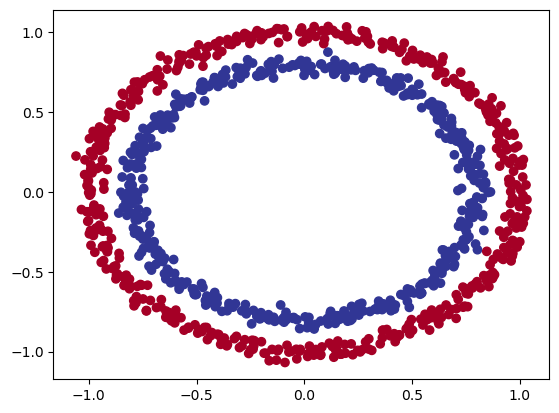

In [4]:
import matplotlib.pyplot as plot

plot.scatter(x=X[:,0],
             y=X[:,1],
             c=y,
             cmap=plot.cm.RdYlBu)


In [5]:
X.shape, y.shape

((1000, 2), (1000,))

In [6]:
import torch

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]


(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [7]:
# Split data into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, # 20% test, 80% train
                                                    random_state=42) # make the random split reproducible

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [8]:
# Standard PyTorch imports
import torch
from torch import nn

# Make device agnostic code
device = "mps" if torch.mps.is_available() else "cpu"
device

'mps'

In [9]:
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)


In [10]:
class CircleModelV0(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.layer_1 = nn.Linear(in_features=2 , out_features=5)
        self.layer_2 = nn.Linear(in_features=5, out_features=1)

    def forward(self, x):
        return self.layer_2(self.layer_1(x))
    

model_0 = CircleModelV0().to(device)
model_0


CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [11]:
# Replicate CircleModelV0 with nn.Sequential
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [12]:
# Make predictions with the model
untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

First 10 predictions:
tensor([[-0.6943],
        [-0.7484],
        [-0.3079],
        [-0.8048],
        [ 0.0806],
        [ 0.0446],
        [-0.4156],
        [-0.2289],
        [-0.3248],
        [-0.7477]], device='mps:0', grad_fn=<SliceBackward0>)

First 10 test labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='mps:0')


In [13]:
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params=model_0.parameters(), lr = 0.1)


In [14]:
def accuracy_fn (y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100 
    return acc

In [15]:
y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.6943],
        [-0.7484],
        [-0.3079],
        [-0.8048],
        [ 0.0806]], device='mps:0', grad_fn=<SliceBackward0>)

In [18]:
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

y_preds = torch.round(y_pred_probs)
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

y_preds.squeeze()

tensor([True, True, True, True, True], device='mps:0')


tensor([0., 0., 0., 0., 1.], device='mps:0', grad_fn=<SqueezeBackward0>)

In [19]:
y_test[:5]

tensor([1., 0., 1., 0., 1.], device='mps:0')

In [21]:
torch.manual_seed(42)

epochs = 100
X_train = X_train.to(device)
y_train = y_train.to(device)

X_test = X_test.to(device)
y_test = y_test.to(device)


for epoch in range(epochs):
    
    model_0.train()

    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    model_0.eval()

    with torch.inference_mode():
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    if(epoch%10==0):
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.71778, Accuracy: 46.12% | Test loss: 0.70894, Test acc: 47.00%
Epoch: 10 | Loss: 0.70872, Accuracy: 46.62% | Test loss: 0.70029, Test acc: 50.50%
Epoch: 20 | Loss: 0.70425, Accuracy: 48.00% | Test loss: 0.69624, Test acc: 49.50%
Epoch: 30 | Loss: 0.70173, Accuracy: 48.75% | Test loss: 0.69417, Test acc: 50.00%
Epoch: 40 | Loss: 0.70010, Accuracy: 48.50% | Test loss: 0.69302, Test acc: 52.50%
Epoch: 50 | Loss: 0.69894, Accuracy: 48.38% | Test loss: 0.69234, Test acc: 53.00%
Epoch: 60 | Loss: 0.69806, Accuracy: 48.38% | Test loss: 0.69192, Test acc: 53.50%
Epoch: 70 | Loss: 0.69736, Accuracy: 48.88% | Test loss: 0.69166, Test acc: 53.00%
Epoch: 80 | Loss: 0.69679, Accuracy: 48.88% | Test loss: 0.69150, Test acc: 53.00%
Epoch: 90 | Loss: 0.69631, Accuracy: 48.75% | Test loss: 0.69140, Test acc: 52.00%


In [22]:
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

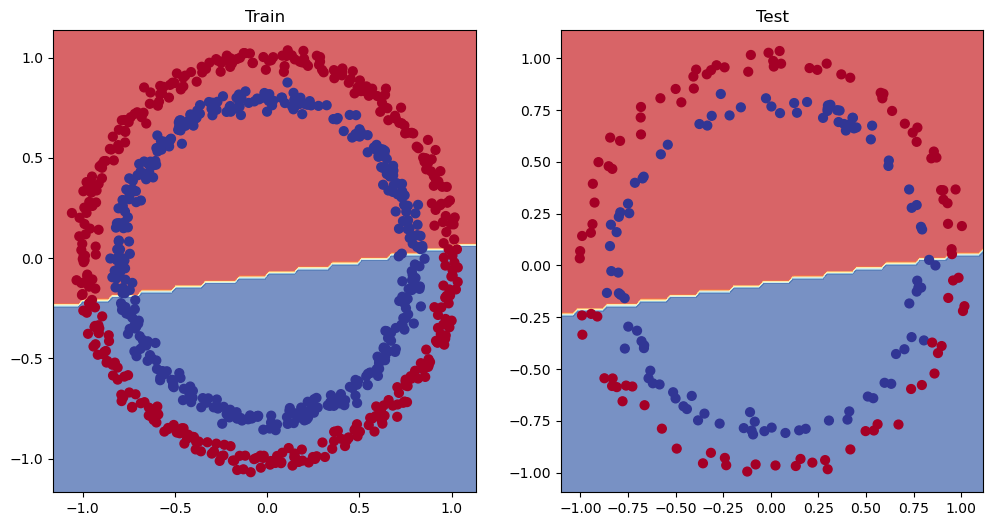

In [23]:
# Plot decision boundaries for training and test sets
plot.figure(figsize=(12, 6))
plot.subplot(1, 2, 1)
plot.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plot.subplot(1, 2, 2)
plot.title("Test")
plot_decision_boundary(model_0, X_test, y_test)